In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing
%matplotlib inline

In [2]:
pm = pd.read_csv('pm2.5.csv')
pm.head()

date   PM2.5
0  2015-01-01  313.22
1  2015-01-02  186.18
2  2015-01-03   87.18
3  2015-01-04  151.84
4  2015-01-05  146.60

In [3]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2009 non-null   object 
 1   PM2.5   2007 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.5+ KB


In [4]:
pm['date'] = pd.to_datetime(pm['date'])

In [5]:
# index of null for a particular column
pm.index[pm['PM2.5'].isnull() == True].tolist()

[954, 955]

In [6]:
# function that returns the null rows if any of the feature is null
def null(df): return df[df.isnull().any(axis=1)]
null(pm)

date  PM2.5
954 2017-08-12    NaN
955 2017-08-13    NaN

In [7]:
# fill null values
pm.set_index('date',inplace=True)
pm['PM2.5'].interpolate(method='time', inplace=True)

In [8]:
pm.index[pm['PM2.5'].isnull() == True].tolist()

[]

In [9]:
pm.reset_index().loc[954:955]

date  PM2.5
954 2017-08-12  23.40
955 2017-08-13  24.97

In [10]:
pm = pm.reset_index()
pm.head()

date   PM2.5
0 2015-01-01  313.22
1 2015-01-02  186.18
2 2015-01-03   87.18
3 2015-01-04  151.84
4 2015-01-05  146.60

In [11]:
# getting day of year
day = []
for i in pm['date']:
    day.append(pd.Period(i, freq='H').day_of_year)
pm['day_of_year'] = day

<AxesSubplot:>

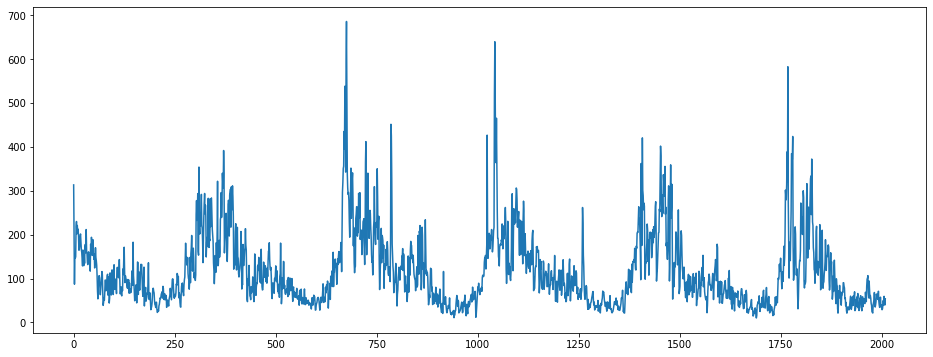

In [12]:
# row is data-frame index
pm['PM2.5'].plot(figsize = (16,6))
# to change to date -> set_index as date

In [13]:
date_index = pm.set_index('date')
date_index.index.year

Int64Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='date', length=2009)

In [14]:
import plotly.express as px
fig = px.line(pm, x='date', y='PM2.5', title='PM2.5 with slider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [15]:
fig.update_xaxes(rangeslider_visible=True,
                rangeselector=dict(buttons=list([
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(count=2, label='2y', step='year', stepmode='backward'),
                    dict(count=3, label='3y', step='year', stepmode='backward'),
                    dict(step='all')
                ]))
                
                
                )
fig.show()

In [16]:
print("has seasonality, but no trend")

has seasonality, but no trend


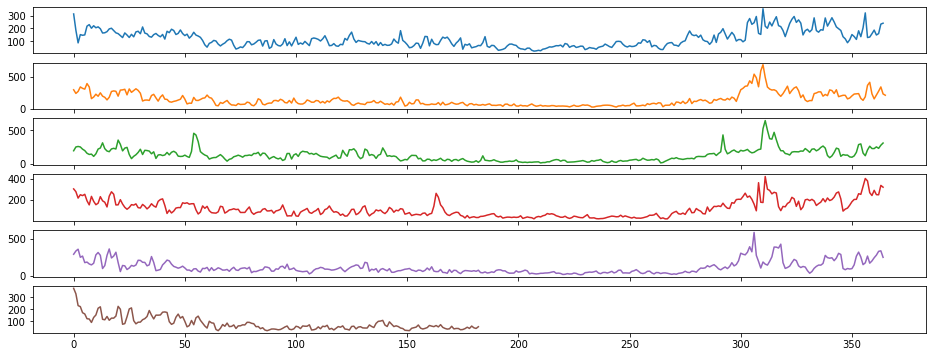

In [17]:
# make sure that the data-frame has no other feature except that which you want to plot

pm_year = date_index.drop(columns=['day_of_year'])

groups = pm_year.groupby(pm_year.index.year)

years = pd.concat([pd.Series(x.values.flatten(), name=y)
for y,x in groups],
axis=1)

years.plot(subplots=True, legend=False, figsize = (16,6))
plt.show()

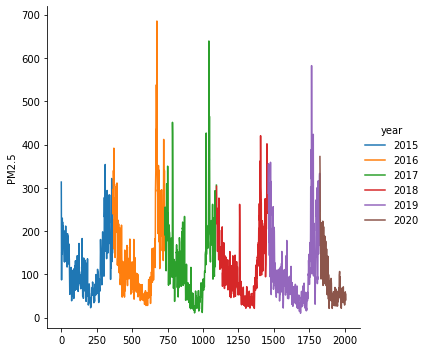

In [18]:
pm['year'] = pm['date'].dt.strftime('%Y')
sns.relplot(x=pm.index,y='PM2.5',hue='year',kind='line',data=pm)

<AxesSubplot:xlabel='date'>

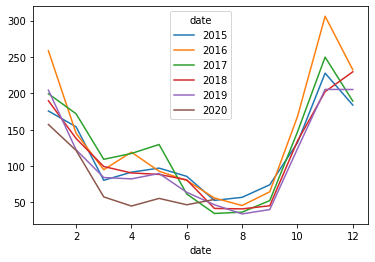

In [19]:
pv = pd.pivot_table(date_index, index=date_index.index.month, columns=date_index.index.year,
                    values='PM2.5', aggfunc='mean')
pv.plot()

<AxesSubplot:xlabel='date'>

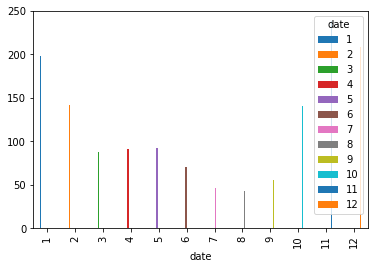

In [20]:
pv = pd.pivot_table(date_index, index=date_index.index.month, columns=date_index.index.month,
                    values='PM2.5', aggfunc='mean')
pv.plot.bar()

In [21]:
period = pd.Period("2015-10-23", freq='H')
period.day_of_year

296

In [22]:
period = pd.Period("2015-10-23", freq='D')
period.day_of_year

296

In [23]:
start_date = "2018-1-1"
end_date = "2020-07-1"

after_start_date =pm["date"] >= start_date
before_end_date = pm["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = pm.loc[between_two_dates]

<AxesSubplot:xlabel='day_of_year', ylabel='PM2.5'>

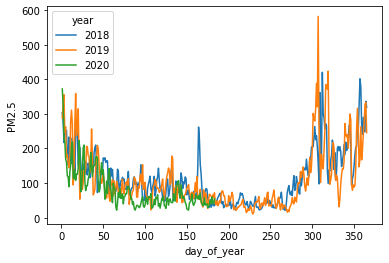

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x='day_of_year',y='PM2.5',hue='year',data=filtered_dates, ax=ax)

<AxesSubplot:xlabel='PM2.5', ylabel='Count'>

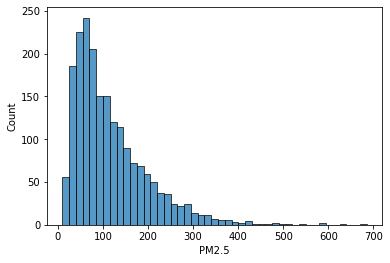

In [25]:
sns.histplot(pm['PM2.5'])

In [26]:
print("data skewed to the left")

data skewed to the left


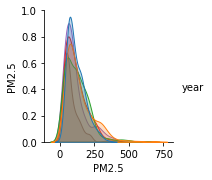

In [27]:
pm = pm[['PM2.5','year']]
sns.pairplot(pm, hue='year')

<AxesSubplot:xlabel='PM2.5', ylabel='Density'>

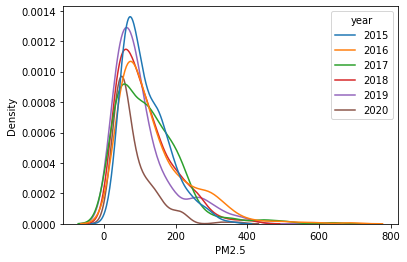

In [28]:
# yearly distributions
sns.kdeplot(data=pm, x="PM2.5", hue="year")

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

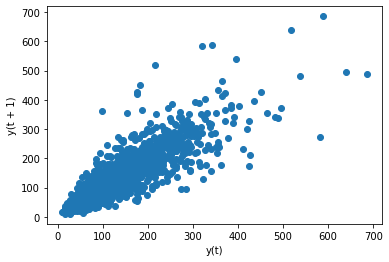

In [29]:
# used to check if the series is random or not
from pandas.plotting import lag_plot
lag_plot(pm['PM2.5'])
# linear implies not random

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



<AxesSubplot:>

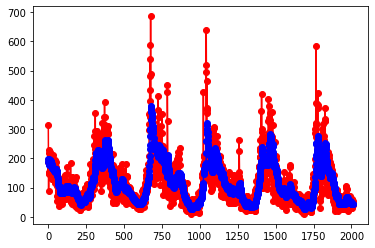

In [30]:
# The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes

model = SimpleExpSmoothing(pm['PM2.5']).fit(smoothing_level=0.1, optimized=True)
pm['PM2.5'].plot(marker='o', color='red')
model.fittedvalues.plot(marker='o', color='blue')

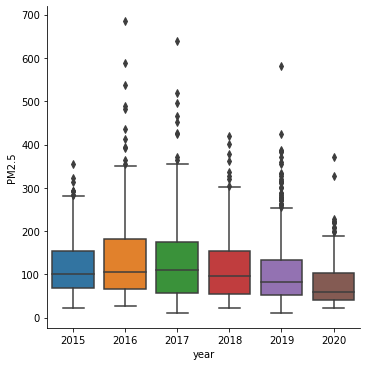

In [31]:
sns.catplot(x='year',y='PM2.5',kind='box',data=pm)

## Decomposition
The decomposition of time series is a statistical task that deconstructs a time series into several components

Trend component - which reflects the long-term progression of the series - Trend can be positive or negative or both

Seasonal Component - includes cyclical component

Noise or residual - remainder of the time series after the other components have been removed

In [32]:
pm = pd.read_csv('pm2.5.csv')
pm['date'] = pd.to_datetime(pm['date'])

In [33]:
pm.set_index('date',inplace=True)
pm['PM2.5'].interpolate(method='time', inplace=True)
pm.reset_index(inplace=True)

In [34]:
pm['quarter'] = pm['date'].dt.quarter

In [35]:
pm.head()

date   PM2.5  quarter
0 2015-01-01  313.22        1
1 2015-01-02  186.18        1
2 2015-01-03   87.18        1
3 2015-01-04  151.84        1
4 2015-01-05  146.60        1

In [36]:
# time series with trends, or with seasonality, are not stationary

# checking for stationary
from statsmodels.tsa.stattools import kpss

# null -> stationary
# alternate -> not stationary


# ct implies trend-component
# tstest = kpss(pm['quarter'],'ct') 

stats, p, lag, critical_values = kpss(pm['quarter'],'c') # c implies no trend

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [37]:
print('p-value:',p)

if p<0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


p-value: 0.1
Series is stationary


In [38]:
pm.set_index('date',inplace=True)

In [39]:
from datetime import datetime
start_date = datetime(2015,1,1)
end_date = datetime(2020,7,1)

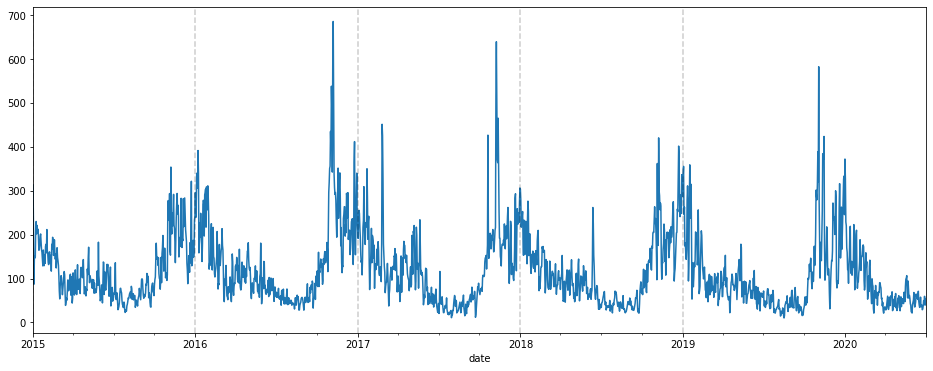

In [40]:
pm['PM2.5'].plot(figsize = (16,6))
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [41]:
rolling_deviations = pd.Series(dtype=float, index = pm['PM2.5'].index)

In [42]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = pm['PM2.5'].loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [43]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

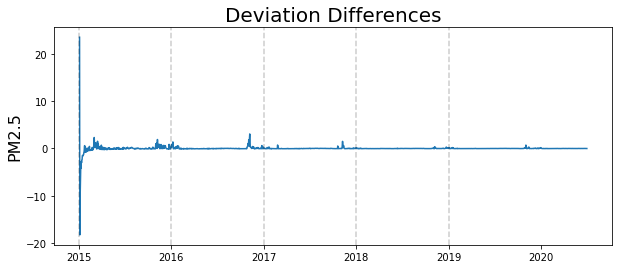

In [44]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('PM2.5', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Seasonal

Text(0, 0.5, 'PM2.5')

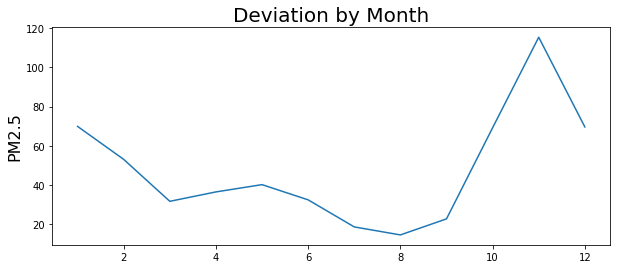

In [45]:
month_deviations = pm['PM2.5'].groupby(lambda d: d.month).std()
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('PM2.5', fontsize=16)

In [46]:
# the above is not necessarily an anamoly
# but we will assume that an anamoly occured on the month of Sept 

In [47]:
sept_data = pm[pm.index.month == 11]
sept_data.head()

PM2.5  quarter
date                       
2015-11-01  277.53        4
2015-11-02  232.40        4
2015-11-03  244.78        4
2015-11-04  293.49        4
2015-11-05  161.78        4

In [48]:
min_dev = 9999999
curr_anomaly = None
for date in sept_data.index:
    other_data = sept_data[sept_data.index != date]
    curr_dev = other_data.std() # check the dtpye for this
    if curr_dev['PM2.5'] < min_dev:
        min_dev = curr_dev['PM2.5']
        curr_anomaly = date

In [49]:
curr_anomaly

Timestamp('2016-11-06 00:00:00')

In [50]:
pm.loc[curr_anomaly]

PM2.5      685.36
quarter      4.00
Name: 2016-11-06 00:00:00, dtype: float64

### using mean of other months to correct the anomaly

In [51]:
arr = pv.to_numpy()
arr

array([[197.48543011,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan, 141.97552941,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,  87.57387097,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,  90.93222222,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
         92.20994624,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,

In [52]:
mean_months = arr.diagonal()
mean_months

array([197.48543011, 141.97552941,  87.57387097,  90.93222222,
        92.20994624,  69.81011111,  46.41762821,  42.85793548,
        55.345     , 140.91193548, 238.2452    , 208.1       ])

In [53]:
rest_mean = mean_months[0:10]
rest_mean = np.append(rest_mean,mean_months[11])
rest_mean

array([197.48543011, 141.97552941,  87.57387097,  90.93222222,
        92.20994624,  69.81011111,  46.41762821,  42.85793548,
        55.345     , 140.91193548, 208.1       ])

In [54]:
np.mean(rest_mean, axis=0)

106.69269174816328

In [55]:
adjusted_data = pm.copy()
adjusted_data.loc[curr_anomaly] = np.mean(rest_mean, axis=0)

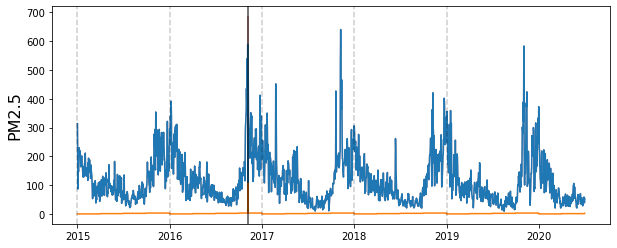

In [56]:
plt.figure(figsize=(10,4))
plt.plot(pm['PM2.5'], color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
# plt.title('', fontsize=20)
plt.ylabel('PM2.5', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

In [57]:
adjusted_data.loc[curr_anomaly]

PM2.5      106.692692
quarter    106.692692
Name: 2016-11-06 00:00:00, dtype: float64

### Seasonal-Trend Decomposition using LOESS (STL)

In [58]:
from statsmodels.tsa.seasonal import STL

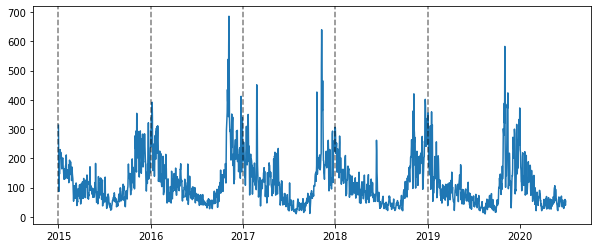

In [59]:
plt.figure(figsize=(10,4))
plt.plot(pm['PM2.5'])
for year in range(2015,2020):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

In [60]:
stl = STL(pm['PM2.5'])
result = stl.fit()

In [61]:
# take the original series and break it into trend and seasonal
seasonal, trend, resid = result.seasonal, result.trend, result.resid

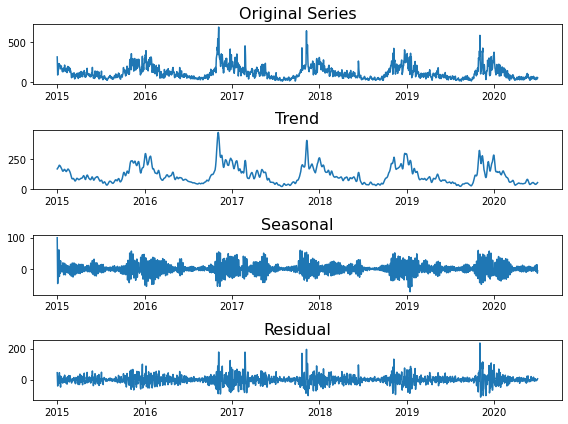

In [62]:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(pm['PM2.5'])
plt.title('Original Series', fontsize=16)

# ignore the seasonal part and plot the trend
plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

# ignore the trend part and plot the seasonal
plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

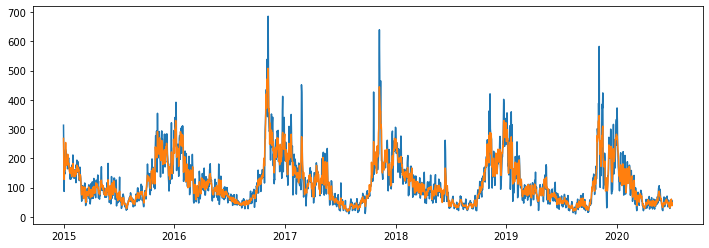

In [63]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(pm['PM2.5'])
plt.plot(estimated)

In [64]:
# the data should have perfectly overlapped 
# the areas where the trend and seasonality do not match is the anamoly

In [65]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(16436.0, 18444.0)

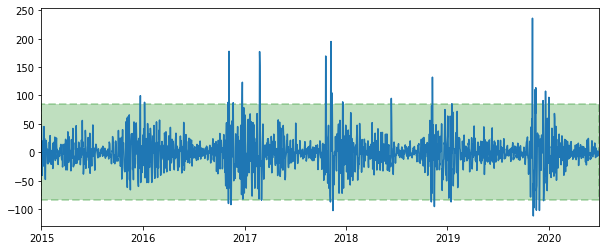

In [66]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2015,1,1), datetime(2020,7,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2015,1,1), datetime(2020,7,1))

In [67]:
anomalies = pm['PM2.5'][(resid < lower) | (resid > upper)]
anomalies

date
2015-12-23    321.52
2016-01-07    391.54
2016-11-02    537.96
2016-11-04    342.45
2016-11-05    588.39
2016-11-06    685.36
2016-11-13    228.16
2016-11-21    340.61
2016-12-24    411.80
2017-02-24    451.25
2017-02-25    425.22
2017-10-20    426.52
2017-11-06    216.53
2017-11-07    517.93
2017-11-08    639.19
2017-11-12    465.08
2017-11-15    192.04
2017-12-20    283.24
2018-06-13    261.77
2018-11-04     97.27
2018-11-08    420.30
2018-11-15     98.53
2019-01-14     94.44
2019-01-17    358.91
2019-11-03    582.28
2019-11-06    101.09
2019-11-08    154.14
2019-11-12    384.34
2019-11-13    383.36
2019-11-15    423.52
2019-11-17     96.34
2019-11-28     31.03
2019-12-11    299.85
2019-12-13     94.62
2019-12-20    316.09
2020-01-01    372.14
Name: PM2.5, dtype: float64

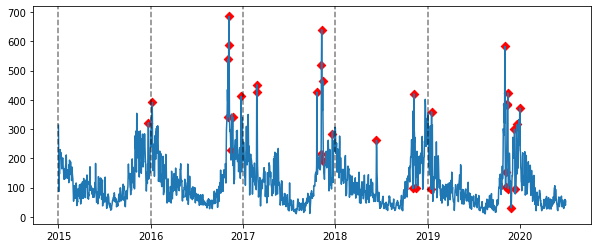

In [68]:
plt.figure(figsize=(10,4))
plt.plot(pm['PM2.5'])
for year in range(2015,2020):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies, color='r', marker='D')

In [69]:
type(anomalies)

pandas.core.series.Series

In [70]:
anomalies.to_frame()

PM2.5
date              
2015-12-23  321.52
2016-01-07  391.54
2016-11-02  537.96
2016-11-04  342.45
2016-11-05  588.39
2016-11-06  685.36
2016-11-13  228.16
2016-11-21  340.61
2016-12-24  411.80
2017-02-24  451.25
2017-02-25  425.22
2017-10-20  426.52
2017-11-06  216.53
2017-11-07  517.93
2017-11-08  639.19
2017-11-12  465.08
2017-11-15  192.04
2017-12-20  283.24
2018-06-13  261.77
2018-11-04   97.27
2018-11-08  420.30
2018-11-15   98.53
2019-01-14   94.44
2019-01-17  358.91
2019-11-03  582.28
2019-11-06  101.09
2019-11-08  154.14
2019-11-12  384.34
2019-11-13  383.36
2019-11-15  423.52
2019-11-17   96.34
2019-11-28   31.03
2019-12-11  299.85
2019-12-13   94.62
2019-12-20  316.09
2020-01-01  372.14